In [1]:
# R version 4.1.0 #
# Load packages: Seurat_4.1.1, RColorBrewer_1.1-3, ggplot2_3.3.6, extrafont_0.18, dplyr_1.0.9, tidyr_1.2.0
# purrr_0.3.4, stringr_1.4.0, zoo_1.8-10

packages = c('Seurat','RColorBrewer','ggplot2','extrafont')
for (p in packages){
    suppressPackageStartupMessages(eval(bquote(library(.(p)))))
}


In [2]:
seurat <- readRDS('source_data/from_GEO/ds_seurat_PCA_UMAP_clusters_ds38_min10_v4.rds')

## cluster 2 (persister) seurat object is used to define the persister cell types used below
## it has already been filtered for samples mentioned up to now in text
seurat_clust2 <- readRDS('source_data/generated/fig3_persister_only.rds') # saved in fig3_persister_only.R
seurat_clust2@active.ident <- seurat_clust2$cell.group



In [3]:
table(seurat_clust2$cell.group)


hipA7 WT_d6   tet  metG 
  975  1855  4576 19611 

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
First group.by variable `ident` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


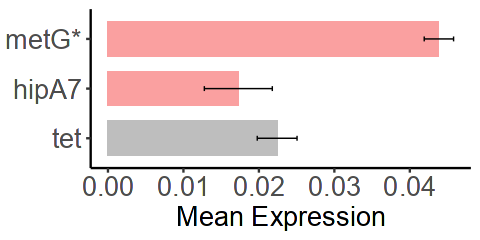

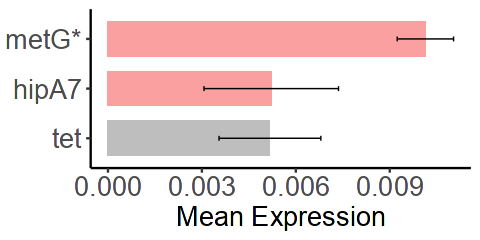

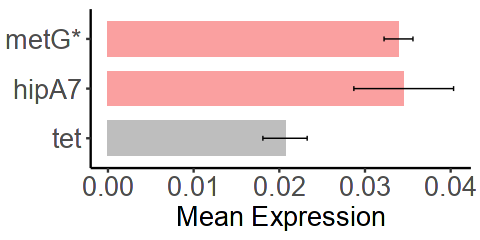

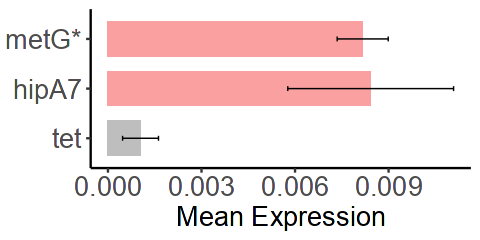

In [4]:
options(repr.plot.width=4, repr.plot.height=2)
seurat_clust2@active.ident <- seurat_clust2$cell.group
slot = 'data'

for (gene in c('lon','yqgE','rpoH','sucA')){
    my_cols = brewer.pal(10,"Spectral")
    term_avg <- colMeans(AverageExpression(seurat,slot='data',features=gene)$RNA)
    mean_all = mean(term_avg)
    cells <- names(subset(seurat_clust2,idents=c('tet'))$cell.type)
    gene_list = subset(seurat,cells=cells)$RNA@data[gene,]
    mean_tet <- mean(exp(gene_list)-1)
    se_tet <- sd(exp(gene_list)-1)/sqrt(length(gene_list))
    cells <- names(subset(seurat_clust2,idents=c('metG'))$cell.type)
    gene_list = subset(seurat,cells=cells)$RNA@data[gene,]
    mean_metG <- mean(exp(gene_list)-1)
    se_metG <- sd(exp(gene_list)-1)/sqrt(length(gene_list))

    cells <- names(subset(seurat_clust2,idents=c('hipA7'))$cell.type)
    gene_list = subset(seurat,cells=cells)$RNA@data[gene,]
    mean_hip <- mean(exp(gene_list)-1)
    se_hip <- sd(exp(gene_list)-1)/sqrt(length(gene_list))

    df <- data.frame(exp=c(mean_metG,mean_hip,mean_tet),names=c('metG*','hipA7','tet'),se=c(se_metG,se_hip,se_tet))
    df$names = factor(df$names,levels=c('tet','hipA7','metG*'))
    p<-ggplot(data=df, aes(x=names, y=exp, fill=names)) +
        geom_bar(stat="identity",width=0.7) + theme_classic() + 
        geom_errorbar(aes(ymin=exp-se, ymax=exp+se), width=.1,size=0.3) + 
        scale_fill_manual(values=c('grey','#FAA0A0','#FAA0A0')) + 
        #geom_hline(yintercept=mean_all, size = 0.5) +
        theme(text=element_text(family= "Arial", size=16),legend.position='none',
            axis.text.y = element_text(family= "Arial", size=16),
            axis.text.x = element_text(family= "Arial", size=16),
            axis.title.y = element_blank(),
            axis.title.x = element_text(family= "Arial", size=16),
            plot.title=element_text(size=16)) + 
        ylab('Mean Expression')
    p <- p + coord_flip()
    print(p)
    ggsave(paste('figures/fig4e_',gene,'.pdf',sep=''),width=4,height=2)
}